# model-1

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from skimage.metrics import structural_similarity as ssim_func
from skimage.metrics import peak_signal_noise_ratio as psnr_func
from skimage.metrics import mean_squared_error as mse_func

In [18]:
# 1. LOAD DATA
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [19]:
# 2. ADD RANDOM GAUSSIAN NOISE (Varying intensities)
def add_noise(images):
    noisy = []
    for img in images:
        # Reduced noise slightly to help CNN convergence initially
        sigma = np.random.uniform(0.2, 0.4) 
        noise = np.random.normal(0, sigma, img.shape)
        noisy.append(np.clip(img + noise, 0, 1))
    return np.array(noisy)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

In [20]:
# 3. CNN AUTOENCODER (Improved Architecture)
input_img = layers.Input(shape=(28, 28, 1))
# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
# Using binary_crossentropy helps prevent the "all black" output on MNIST
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Increase epochs to at least 10 for meaningful patterns
autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=128, shuffle=True, verbose=1)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2352
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0923
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0873
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0849
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0836
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0825
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0817
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0811
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0808
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0803


In [21]:
# 4. MATH GAUSSIAN FILTER FROM SCRATCH
def manual_gaussian_denoise(image, sigma=1.0):
    size = 3
    # Create Kernel
    ax = np.linspace(-(size // 2), size // 2, size)
    gauss = np.exp(-0.5 * (ax**2 / sigma**2))
    kernel = np.outer(gauss, gauss)
    kernel /= kernel.sum()
    
    # Simple Manual Convolution
    img = image.squeeze()
    padded = np.pad(img, 1, mode='constant')
    out = np.zeros_like(img)
    for i in range(28):
        for j in range(28):
            out[i,j] = np.sum(padded[i:i+3, j:j+3] * kernel)
    return out.reshape(28, 28, 1)

In [22]:
# 5. PREDICT AND COMPARE (Digits 0-9)
indices = [np.where(y_test == i)[0][0] for i in range(10)]
gt_samples = x_test[indices]
noisy_samples = x_test_noisy[indices]
cnn_results = autoencoder.predict(noisy_samples)
math_results = np.array([manual_gaussian_denoise(img) for img in noisy_samples])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


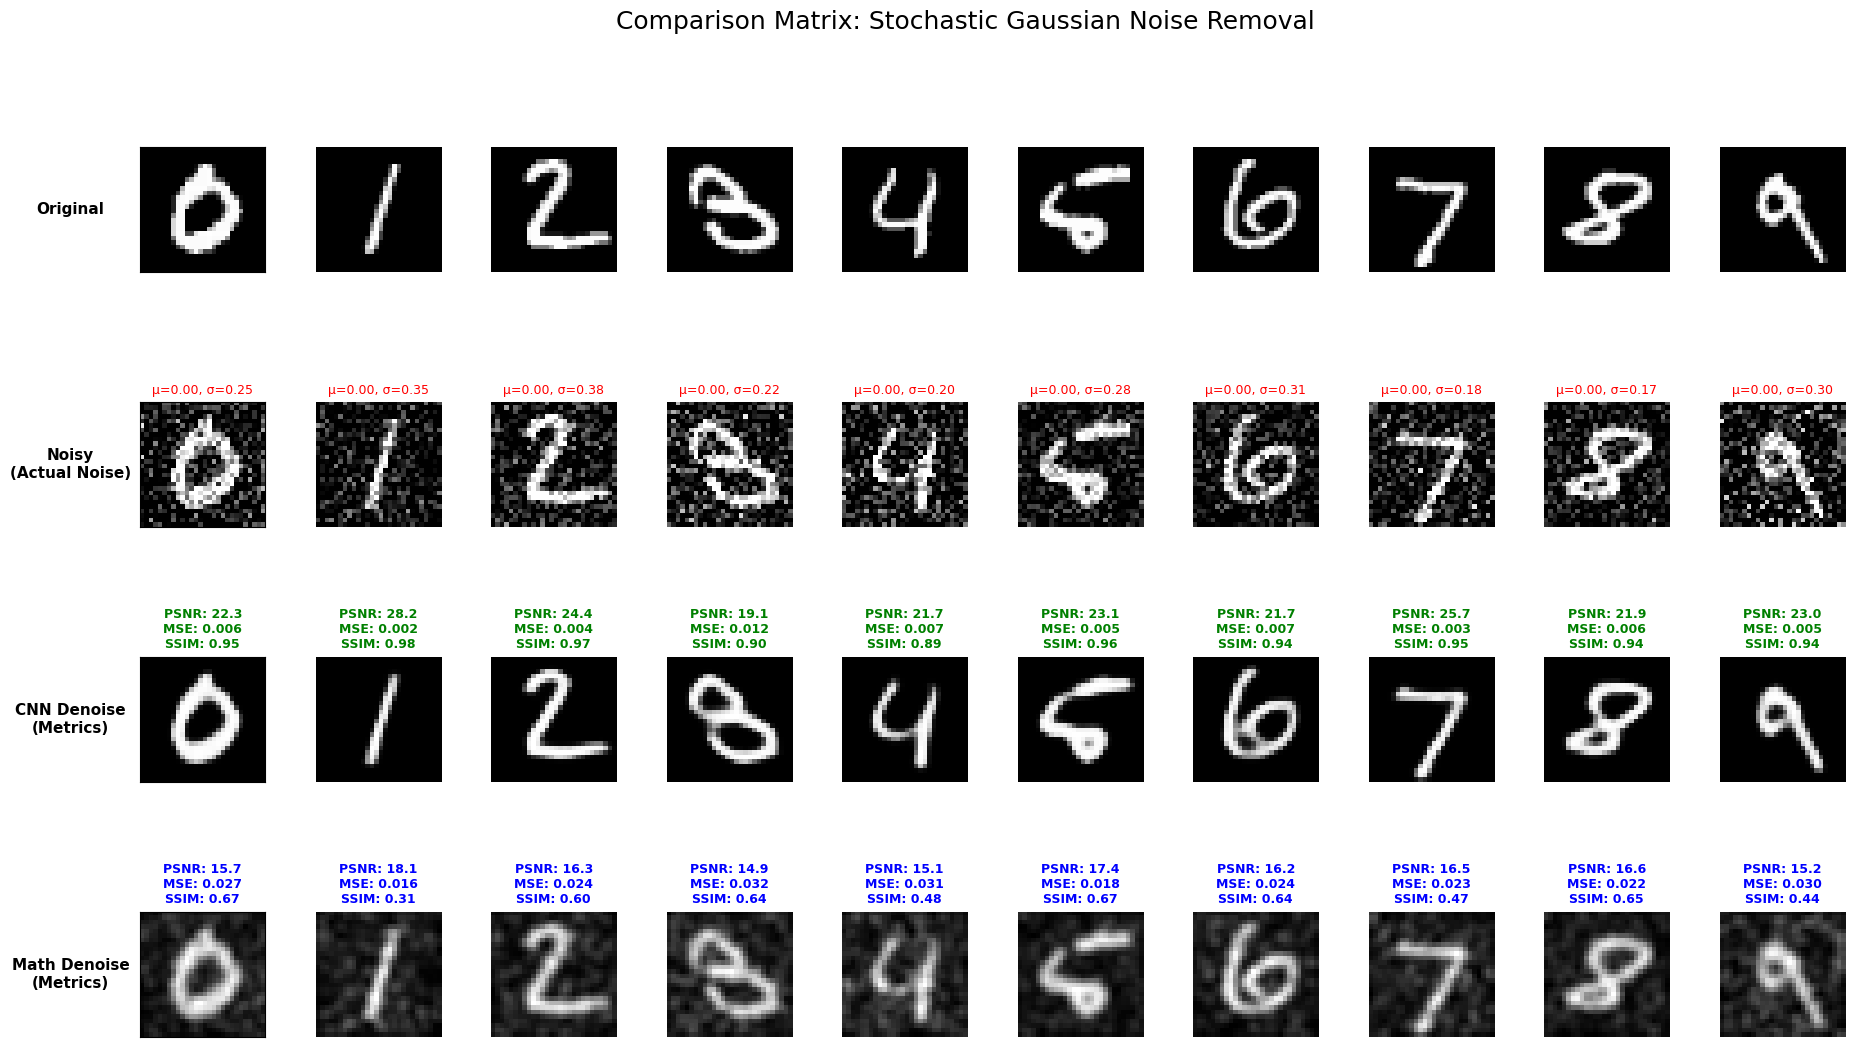

In [24]:
# --- Updated Step 2: Track noise parameters during generation ---
def add_noise_with_params(images):
    noisy_list = []
    params_list = []
    for img in images:
        mean = 0.0  # Common for Gaussian noise
        sigma = np.random.uniform(0.15, 0.4) 
        noise = np.random.normal(mean, sigma, img.shape)
        noisy_img = np.clip(img + noise, 0, 1)
        
        noisy_list.append(noisy_img)
        params_list.append((mean, sigma))
    return np.array(noisy_list), params_list

# Generate noisy test samples and store their specific noise levels
x_test_noisy, noise_params = add_noise_with_params(x_test)

# --- Updated Step 6: Enhanced Plot with Dynamic Labels ---
fig, axes = plt.subplots(4, 10, figsize=(22, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

labels = ["Original", "Noisy\n(Actual Noise)", "CNN Denoise\n(Metrics)", "Math Denoise\n(Metrics)"]

for i in range(10):
    # Get the noise parameters for the current digit column
    m, s = noise_params[indices[i]]
    
    imgs = [gt_samples[i], noisy_samples[i], cnn_results[i], math_results[i]]
    
    for r in range(4):
        ax = axes[r, i]
        ax.imshow(imgs[r].squeeze(), cmap='gray')
        ax.axis('off')
        
        # Row Labels (Only on the first column)
        if i == 0:
            ax.set_ylabel(labels[r], rotation=0, labelpad=50, fontsize=11, fontweight='bold', va='center')
            ax.axis('on') # Turn on to show ylabel
            ax.set_xticks([]); ax.set_yticks([]) # But hide ticks

        # Label Row 1: The specific noise applied
        if r == 1:
            ax.set_title(f"µ={m:.2f}, σ={s:.2f}", fontsize=9, color='red')

        # Label Rows 2 & 3: Comparison Metrics
        if r >= 2:
            psnr_v = psnr_func(gt_samples[i].squeeze(), imgs[r].squeeze(), data_range=1.0)
            mse_v = mse_func(gt_samples[i].squeeze(), imgs[r].squeeze())
            ssim_v = ssim_func(gt_samples[i].squeeze(), imgs[r].squeeze(), data_range=1.0)
            
            # Using color coding: Green for good, Black for standard
            color = 'green' if r == 2 else 'blue'
            ax.set_title(f"PSNR: {psnr_v:.1f}\nMSE: {mse_v:.3f}\nSSIM: {ssim_v:.2f}", 
                         fontsize=9, color=color, fontweight='bold')

plt.suptitle("Comparison Matrix: Stochastic Gaussian Noise Removal", fontsize=18, y=0.98)
plt.show()